# Measurement uncertainty calculations

# Introduction

### Definitions
**Measurement uncertainty** is defined in the ISO ‘Guide to the Expression of Uncertainty in Measurement’ as ‘a parameter, associated with the result of a measurement that characterises the dispersion of the values that  could  reasonably  be  attributed  to  the  measurand’.  The  **measurand**  is  the  ‘quantity  intended  to  be measured’.

### Purpose
An estimate  of  uncertainty  provides  a  quantitative  indication  of  the  quality  of  a  measurement  result. Rather than using a ‘bottom-up’ approach which examines the inputs to a method and considers how they might influence results, the biochemical genetics units uses a ‘top-down’ approach using the information from method outputs (e.g. the observed variability of replicate measurement results), as described in ADD.BIO 6680: Estimating measurement uncertainty in the biochemical genetics unit. This notebook attempts to outline these steps.

## Imports, configuration

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Optional Pandas configuration.

Since some columns have long names, change the maximum column width in Pandas so we can see the full name. We also may want to see the full list of rows, in some cases.


In [52]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 20)

## Import mappings

The mappings file contains:
* mappings to link the Assay and Measurand to the name of the QC material in [Randox Acusera 24:7](https://qc.randox.com/Acusera#Home)
* the lower and upper limit of quantitation, as described in the assay SOP. If the lower or upper limits are not specified in the SOP, these are given as 0 and 9999999 respectively. If more than one limit is provided (for example, different limits for different instruments), then the lower lower limit or higher upper limit was used.

In [3]:
mappings = pd.read_csv('data\\raw_data\\mappings.csv')
mappings.head()

,Assay,Measurand,Randox,reportable_range_lower,reportable_range_upper,reportable_range_source
0,Amino acids (CSF),Glycine,NaN,5.0,2000.0,ADD.BIO 66965 (v2.5)
1,Amino acids (CSF),Serine,NaN,5.0,2000.0,ADD.BIO 66965 (v2.5)
2,Amino acids (Plasma),Alanine,Alanine Clinical Chemistry Cation exchange chromatography umol/l Biochrom,10.0,2000.0,ADD.BIO 66965 (v2.5)
3,Amino acids (Plasma),Alloisoleucine,Alloisoleucine Clinical Chemistry Cation exchange chromatography umol/l Biochrom,0.0,9999999.0,NaN
4,Amino acids (Plasma),Arginine,Arginine Clinical Chemistry Cation exchange chromatography umol/l Biochrom,5.0,2000.0,ADD.BIO 66965 (v2.5)


# Obtain an estimate of the precision of the measurement procedure

## Import measurement uncertainty report from Randox Acusera 24:7

The measurement uncertainty report contains stiastics on each lot number in Randox Acusera. Data points that have been rejected are not included in the analysis.

when importing the data, exclude QC lots where the measurand concentration is outside the reportable range

In [4]:
def import_randox(filename, mappings):
    '''
    Imports measurement uncertainty excel file from Randox Acusera, then
    maps these to the Assay and Measurands via the Mappings file
    
    Drops any statistics for QCs that are below the limit of quantitation
    (if defined in the mappings file)
    '''
    randoxMU = pd.read_excel(filename)
    randoxMU = randoxMU.rename(columns={'Assay':'Randox'})
    randoxMU = randoxMU.drop(columns=['Intra','Inter','ExpandedUOM'])
    randoxMU = randoxMU.sort_values(by=['Randox','Mean'])
    

    
    ## Calculate the percentage CV
    randoxMU['% CV'] = round(randoxMU['UOM']/randoxMU['Mean'] * 100,1)
    
    ## Urine, Plasma and CSF QCs are all stored in Randox under the same name.
    ## Add an extra note in the Randox column for urine QC to distinguish these,
    ## identified by the lot number starting with "AAU"
    randoxMU['Randox'][randoxMU['Lot Name'].str[:3] == 'AAU'] = randoxMU['Randox'].astype(str) + ' (Urine)'
    
    ## Read the mappings csv file and join this with the QC data to show the Assay and Measurand name, and import LoQ
    mappings = pd.read_csv(mappings)
    qc_data = mappings.merge(right=randoxMU,on='Randox',how='inner')
    
    ## Drop any QC values that are outside the reportable interval
    qc_data = qc_data.query('Mean >= reportable_range_lower')
    qc_data = qc_data.query('Mean <= reportable_range_upper')
    
    return qc_data

In [5]:
qc_data = import_randox("data\\raw_data\\Uncertainty of Measurement.xlsx"
                        ,"data\\raw_data\\mappings.csv")

C:\Users\nickf\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [6]:
qc_data.head()

,Assay,Measurand,Randox,reportable_range_lower,reportable_range_upper,reportable_range_source,Instrument,Lot Name,Count,Mean,UOM,% CV
0,Amino acids (Plasma),Alanine,Alanine Clinical Chemistry Cation exchange chromatography umol/l Biochrom,10.0,2000.0,ADD.BIO 66965 (v2.5),AAA+,AA2019.1571,52,324.173,10.525,3.2
1,Amino acids (Plasma),Alanine,Alanine Clinical Chemistry Cation exchange chromatography umol/l Biochrom,10.0,2000.0,ADD.BIO 66965 (v2.5),AAA+,AA2019.1572,52,933.115,35.659,3.8
2,Amino acids (Plasma),Alloisoleucine,Alloisoleucine Clinical Chemistry Cation exchange chromatography umol/l Biochrom,0.0,9999999.0,NaN,AAA+,AAA_200401,48,76.562,2.492,3.3
3,Amino acids (Plasma),Arginine,Arginine Clinical Chemistry Cation exchange chromatography umol/l Biochrom,5.0,2000.0,ADD.BIO 66965 (v2.5),AAA+,AA2019.1571,52,25.346,1.909,7.5
4,Amino acids (Plasma),Arginine,Arginine Clinical Chemistry Cation exchange chromatography umol/l Biochrom,5.0,2000.0,ADD.BIO 66965 (v2.5),AAA+,AA2019.1572,52,514.731,17.448,3.4


## Obtain an estimate of the precision of the measurement procedure

The measurement uncertainty report from Randox needs to be processed to:
* exclude QC lots where the measurand concentration is outside the reportable range (done above when importing the data)
* exclude QC lots with low counts
* calculate averages for each measurand
* present the data by assay in a useful format

First,  create a summary for each lot number that shows some basic statistics by pivoting existing data and removing lots with low counts.

In [7]:
def qc_lot_summary(qc_data, assay, count_thresh=1):
    '''
    Returns a dataframe containing lot number statistics for the assay QC data
    Excludes any statistics with fewer than count_thresh values
    '''
    ## Define the order in which columns should appear
    column_order = ['Count','Mean','UOM','% CV']
    
    ## Filter the main qc data file for only the assay we are interested in, and drop unnecessary columns
    assay_qc_data = qc_data[qc_data['Assay'] == assay].drop(columns=['Assay','Randox'])
    
    ## Drop any QC values where there are fewer than count_thresh datapoints
    assay_qc_data = assay_qc_data[assay_qc_data['Count'] >= count_thresh]
    
    ## Round the data to 2 decimal places
    assay_qc_data = assay_qc_data.round(2)
    
    ## Pivot the data and reorder levels
    assay_qc_pivot = assay_qc_data.pivot(index='Measurand', values=column_order, columns=['Lot Name','Instrument'])
    assay_qc_pivot = assay_qc_pivot.swaplevel(0,2, axis=1).sort_index(axis=1)

    ## Reorder columns and fill blanks
    assay_qc_pivot = assay_qc_pivot.reindex(column_order, level=2, axis=1)
    assay_qc_pivot = assay_qc_pivot.fillna('')
    
    return assay_qc_pivot

In [8]:
qc_lot_summary(qc_data,'Organic acids', 10)

Instrument                              GC-MSD2                    \
Lot Name                              OA2017.07                     
                                          Count   Mean   UOM % CV   
Measurand                                                           
Urine methylmalonate/creatinine ratio       100  34.68  1.95  5.6   
Urine orotate/creatinine ratio                                      

Instrument                                                           
Lot Name                              SAU2018.2172                   
                                             Count  Mean   UOM % CV  
Measurand                                                            
Urine methylmalonate/creatinine ratio                                
Urine orotate/creatinine ratio                  32  18.3  1.26  6.9

Next, we aggregate the data over all lots numbers and instruments (excluding those whe the count is less than the count threshold) by summing the total counts and averaging the measurement uncertainty and %CV.

In [9]:
def mean2(series):
    if (series.max() / series.min()) < 2:
        return series.mean()
    else:
        return '% CV different'

In [10]:
def qc_aggregated(qc_data, assay, count_thresh=1):
    '''
    Returns total number of QC datapoints for each analyte and average of each lot number measurement uncertainty and %CV
    Excludes any statistics with fewer than count_thresh values
    '''
    filtered = qc_data[qc_data['Assay'] == assay].drop(columns=['Assay','Randox'])
    filtered = filtered[filtered['Count'] >= count_thresh]
    aggregated = filtered.groupby('Measurand').agg({'Count':'sum',
                                              'UOM':'mean',
                                              '% CV':'mean'})
    return aggregated.round(2)

In [11]:
qc_aggregated(qc_data,'Organic acids',10)

,Count,UOM,% CV
Measurand,,,
Urine methylmalonate/creatinine ratio,100,1.95,5.6
Urine orotate/creatinine ratio,32,1.26,6.9


We can then combine the lot statistics and aggregated statistics

In [12]:
def qc_lot_summary_with_means(qc_data, assay, count_thresh=1):
    '''
    Returns a dataframe containing both lot number statistics and aggregated statistics
    Excludes any statistics with fewer than count_thresh values
    '''
    assay_qc_pivot = qc_lot_summary(qc_data, assay, count_thresh)
    aggregated = qc_aggregated(qc_data, assay, count_thresh)
    
    assay_qc_pivot[('All instrument','All lots','Count')] = aggregated['Count']
    assay_qc_pivot[('All instrument','All lots','UOM')] = aggregated['UOM']
    assay_qc_pivot[('All instrument','All lots','% CV')] = aggregated['% CV']
    
    return assay_qc_pivot.round(2)

In [13]:
qc_lot_summary_with_means(qc_data, 'Amino acids (Plasma)', 10)

Instrument            AAA+                                                   \
Lot Name       AA2019.1571                      AA2019.1572                   
                     Count    Mean    UOM  % CV       Count     Mean    UOM   
Measurand                                                                     
Alanine                 52  324.17  10.52   3.2          52   933.12  35.66   
Alloisoleucine                                                                
Arginine                52   25.35   1.91   7.5          52   514.73  17.45   
Aspartic acid           52   18.52   1.04   5.6          50       87   4.67   
Citrulline              52   21.12   1.23   5.8          51   412.65  17.72   
Glutamic acid           52   57.56   4.32   7.5          51    243.1  14.78   
Glutamine               52  571.67  25.65   4.5          52  1171.77  60.52   
Glycine                 52  300.15  10.38   3.5          52  1042.56  44.18   
Histidine               52    99.6   3.83   3.8          52   393.25  17.28   
Isoleucine              59   30.73   2.14     7          59   405.63  14.58   
Leucine                 59   83.76   2.74   3.3          59   888.25  29.52   
Lysine                  52   76.65    3.1     4          52   490.96  21.43   
Methionine              59   10.07   1.22  12.1          58   255.98  13.65   
Ornithine               52   63.04   2.25   3.6          52   664.15  25.24   
Phenylalanine           57   76.61   3.21   4.2          59   967.78  34.55   
Proline                 52  189.35  13.07   6.9          50   542.18   40.2   
Serine                  52   55.98    2.3   4.1          52   453.36  15.78   
Taurine                 52   52.69   3.03   5.7          51   425.26  18.89   
Threonine               52  100.81   3.37   3.3          52   406.94  14.75   
Tryptophan              50  136.06    8.1     6          50   307.94  18.25   
Tyrosine                59   49.12   2.03   4.1          59    920.7  34.91   
Valine                  59   152.3   6.68   4.4          58   850.88  29.75   

Instrument                                       All instrument               
Lot Name            AAA_200401                         All lots               
               % CV      Count   Mean   UOM % CV          Count    UOM  % CV  
Measurand                                                                     
Alanine         3.8                                         104  23.09  3.50  
Alloisoleucine              48  76.56  2.49  3.3             48   2.49  3.30  
Arginine        3.4                                         104   9.68  5.45  
Aspartic acid   5.4                                         102   2.85  5.50  
Citrulline      4.3                                         103   9.48  5.05  
Glutamic acid   6.1                                         103   9.55  6.80  
Glutamine       5.2                                         104  43.09  4.85  
Glycine         4.2                                         104  27.28  3.85  
Histidine       4.4                                         104  10.55  4.10  
Isoleucine      3.6                                         118   8.36  5.30  
Leucine         3.3                                         118  16.13  3.30  
Lysine          4.4                                         104  12.26  4.20  
Methionine      5.3                                         117   7.43  8.70  
Ornithine       3.8                                         104  13.75  3.70  
Phenylalanine   3.6                                         116  18.88  3.90  
Proline         7.4                                         102  26.64  7.15  
Serine          3.5                                         104   9.04  3.80  
Taurine         4.4                                         103  10.96  5.05  
Threonine       3.6                                         104   9.06  3.45  
Tryptophan      5.9                                         100  13.18  5.95  
Tyrosine        3.8                              

Note: for the acylcarnitines assay, some measurands have data for one QC lot, and some measurands do not appear at all. This is because the measurand is present at less than the limit of quantitation

In [14]:
qc_lot_summary_with_means(qc_data, 'Acylcarnitines (Blood spot)', 10)

Instrument                                   API4000                     \
Lot Name                                      1508L1                      
                                               Count   Mean   UOM  % CV   
Measurand                                                                 
C10 (Decanoyl) Carnitine                          76   0.33  0.03   8.5   
C12 carnitine                                     76   0.47  0.06  13.7   
C14 (Myristoyl) Carnitine                         74   0.51  0.05  10.5   
C16 (Palmitoyl) Carnitine                         63   1.27  0.14  10.9   
C18 carnitine                                     64   0.64  0.08  12.4   
C18:1 carnitine                                   76   1.11  0.15  13.3   
C18:2 carnitine                                   76   0.22  0.03  12.5   
C2 (Acetyl) carnitine                                                     
C3 (Propionyl) carnitine                          75   0.76  0.06   7.6   
C4 (Butyryl) Carnitine                            76   0.12  0.03  21.6   
C5 (Isovaleryl) Carnitine                         42    0.5  0.06  13.1   
C6 (Hexanoyl) Carnitine                           49   0.24  0.02   8.2   
C8 (Octanoyl) Carnitine                           74   0.39  0.03   7.7   
Free carnitine                                    73  38.39  2.82   7.3   
Glutaryl carnitine                                76   0.55  0.08  13.8   
Hydroxybutyryl / malonyl carnitine                                        
Methylmalonyl  / Hydroxyisovaleryl carnitine      55   0.36  0.03   7.2   

Instrument                                                               \
Lot Name                                     1508L2                       
                                              Count    Mean   UOM  % CV   
Measurand                                                                 
C10 (Decanoyl) Carnitine                       75.0    1.43  0.11   7.4   
C12 carnitine                                  74.0    6.54  0.67  10.2   
C14 (Myristoyl) Carnitine                      70.0    3.77  0.24   6.3   
C16 (Palmitoyl) Carnitine                      51.0   11.26  0.55   4.9   
C18 carnitine                                  62.0    4.66  0.36   7.7   
C18:1 carnitine                                75.0    1.07  0.12  10.8   
C18:2 carnitine                                67.0    0.20  0.02   7.7   
C2 (Acetyl) carnitine                          71.0    8.80  0.58   6.6   
C3 (Propionyl) carnitine                       76.0    7.78  0.55   7.0   
C4 (Butyryl) Carnitine                         74.0    3.83  0.22   5.6   
C5 (Isovaleryl) Carnitine                      62.0    2.43  0.17   7.0   
C6 (Hexanoyl) Carnitine                        22.0    0.98  0.07   7.1   
C8 (Octanoyl) Carnitine                        76.0    1.99  0.14   7.1   
Free carnitine                                 70.0  179.01  9.66   5.4   
Glutaryl carnitine                             74.0    2.04  0.25  12.2   
Hydroxybutyryl / malonyl carnitine             41.0    0.11  0.01   9.1   
Methylmalonyl  / Hydroxyisovaleryl carnitine   35.0    0.34  0.02   5.0   

Instrument                                   All instrument               
Lot Name                                           All lots               
                                                      Count   UOM   % CV  
Measurand                                                                 
C10 (Decanoyl) Carnitine                                151  0.07   7.95  
C12 carnitine                                           150  0.37  11.95  
C14 (Myristoyl) Carnitine                               144  0.14   8.40  
C16 (Palmitoyl) Carnitine                               114  0.35   7.90  
C18 carnitine                                           126  0.22  10.05  
C18:1 carnitine                                         151  0.13  12.05  
C18:2 carnitine                                         143  0.02  10.10  
C2 (Acetyl) carnitine  

We can export the data for all assays as seperate .csv files which are saved in the \data\processed\qc_summary_tables folder

In [15]:
def assay_qc_data_export(df, count_thresh):
    '''
    Createsa a qc summary table for each assay (excluding any statistics
    with fewer than count_thresh value per lot number / instrument.
    
    Exports each table to a .csv file in the processed data folder
    '''
    for assay in df['Assay'].unique():
        try:
            filepath = os.path.abspath('') + '\\data\\processed\\qc_summary_tables\\' + assay + '.csv'
            table = qc_lot_summary_with_means(df, assay, count_thresh)
            table.to_csv(filepath)
            print(f'{assay} succesfully exported')
        except:
            print(f'!!! Error in exporting data for {assay}')

In [53]:
assay_qc_data_export(qc_data,10)

Amino acids (Plasma) succesfully exported
Amino acids (Urine) succesfully exported
Biotinidase (Plasma) succesfully exported
Acylcarnitines (Blood spot) succesfully exported
Immunoreactive trypsinogen (Blood spot) succesfully exported
Thyroid Stimulating Hormone (Blood spot) succesfully exported
Chitotriosidase (Plasma) succesfully exported
Creatine and guanidinoacetate (Plasma) succesfully exported
Creatine and guanidinoacetate (Urine) succesfully exported
Total homocysteine (Plasma) succesfully exported
Newborn screening for inherited metabolic disorders succesfully exported
Newborn screening for sickle cell disorders succesfully exported
Organic acids succesfully exported
Chloride (Sweat) succesfully exported
Immunosuppressant drugs succesfully exported
5-hydroxyindoleacetic acid (Urine) succesfully exported
Glycosaminoglycans (Urine) succesfully exported
Metanephrines (Urine) succesfully exported
Porphobilinogen (Urine) succesfully exported
Sulfocysteine (Urine) succesfully exporte

# Obtain an estimate of the measurement bias and its uncertainty

Measurement bias and its uncertainty can be estimnated from the regular participation in external quality assessment (EQA).

### Import results and target values

Import EQA results from a csv file (UKNEQAS results can be obtained using EQA data scraper)

In [33]:
import glob

In [34]:
folder = 'data//raw_data//eqa_results//results_targets'

In [74]:
def import_eqa(folder):
    df = pd.concat(map(pd.read_csv, glob.glob(os.path.join(folder, "*.csv"))),join='outer',ignore_index=True)
    df['Standard Uncertainty'] = df['Standard Uncertainty'].fillna(0)
    df = df.rename(columns={'Analyte':'EQA analyte name'})
    return df

In [75]:
eqa_results = import_eqa(folder)

In [76]:
eqa_results

,Scheme name,Specimen,EQA analyte name,Result,Targ,n,Pool,Standard Uncertainty
0,ERNDIM Amino Acids,2020.08,2-Aminobutyric acid,NaN,54,196.0,NaN,0.0
1,ERNDIM Amino Acids,2020.08,Alanine,602,559,267.0,NaN,0.0
2,ERNDIM Amino Acids,2020.08,Alloisoleucine,38,44,194.0,NaN,0.0
3,ERNDIM Amino Acids,2020.08,Arginine,174,164,266.0,NaN,0.0
4,ERNDIM Amino Acids,2020.08,Argininosuccinic acid,NaN,18,121.0,NaN,0.0
...,...,...,...,...,...,...,...,...
1087,Sweat Testing,188B,Sweat Chloride,25,25.7,NaN,265,0.0
1088,Sweat Testing,188C,Sweat Chloride,45,45.7,NaN,266,0.0
1089,Sweat Testing,188A,Chloride interp,N,N,NaN,264,0.0
1090,Sweat Testing,188B,Chloride interp,N,N,NaN,265,0.0


### Standard uncertainty in the target value

The standard uncertainty in the target value is not included in the result and target value UKNEQAS scrape, but can be obtained from the UKNEQAS analyte information scrape.

In [53]:
def standard_uncertainty_data(filename):
    '''
    Extract just the standard uncertainty from an analyte information UKNEQAS scrape
    '''
    
    df = pd.read_csv(filename)
    standard_uncertainty = df[df['Name'] == 'Standard Uncertainty']
    
    #Assumes that there are three samples per distribution for all schemes (might be dangerous)
    standard_uncertainty['Distribution'][0::3] = standard_uncertainty['Distribution'][0::3].astype(str) + 'A'
    standard_uncertainty['Distribution'][1::3] = standard_uncertainty['Distribution'][1::3].astype(str) + 'B'
    standard_uncertainty['Distribution'][2::3] = standard_uncertainty['Distribution'][2::3].astype(str) + 'C'
    
    standard_uncertainty = standard_uncertainty.rename(columns={'Value':'Standard Uncertainty','Analyte name':'Analyte','Distribution':'Specimen'})
    standard_uncertainty = standard_uncertainty.drop(columns='Name')
    return standard_uncertainty

In [54]:
std_uncert = standard_uncertainty_data('data\\raw_data\\eqa_results\\eqa_analyte_information\\EQA_analyte_information_urine_catecholamines_236-246.csv')

C:\Users\nickf\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\nickf\Anaconda3\lib\site-packages\pandas\core\series.py:1027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_with(key, value)
C:\Users\nickf\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point

In [55]:
std_uncert.head()

,Standard Uncertainty,Analyte,Specimen,Scheme name
3,0.12,Metadrenaline (umol/24h),236A,Urinary Catecholamines & Metabolite
14,0.0,Metadrenaline (umol/24h),236B,Urinary Catecholamines & Metabolite
25,0.37,Metadrenaline (umol/24h),236C,Urinary Catecholamines & Metabolite
36,0.06,Normetadrenaline (umol/24h),236A,Urinary Catecholamines & Metabolite
47,0.01,Normetadrenaline (umol/24h),236B,Urinary Catecholamines & Metabolite


In [175]:
std_uncert.to_csv('data\\raw_data\\eqa_results\\standard_uncertainty\\catecholamines.csv',index=False)

It is probably easier to merge this manually via Excel (then 

## Calculate EQA statistics

The EQA data does not contain the specimen bias or percentage uncertainty in the target. We can calculate thse from the result, target value and standard uncertainty of the target value (after excluding non-numeric results and target values)

In [58]:
def eqa_calculations(df):
    # Remove rows with non-numeric result or target values
    # https://stackoverflow.com/questions/21771133/finding-non-numeric-rows-in-dataframe-in-pandas/44178063
    data_columns = ['Result','Targ']
    num_df = (df.drop(data_columns, axis=1)
         .join(df[data_columns].apply(pd.to_numeric, errors='coerce')))

    num_df = num_df[num_df[data_columns].notnull().all(axis=1)]
    
    ##Calculate percentage bias
    num_df['% Bias'] = round(100*(num_df['Result'] - num_df['Targ'])/num_df['Targ'],1)
    
    ## Calculate percentage uncertainty in the target value
    num_df['% uncertainty in target value'] = round(100*num_df['Standard Uncertainty']/num_df['Targ'],1)
    
    return num_df

In [59]:
eqa_calculated = eqa_calculations(eqa_results)

In [ ]:
############## NEED TO EXCLUDE OUTLIERS LIKE THESE:

In [79]:
eqa_calculated[abs(eqa_calculated['% Bias']) > 100]

,Scheme name,Specimen,Analyte,n,Pool,Standard Uncertainty,Result,Targ,% Bias,% uncertainty in target value
33,ERNDIM Amino Acids,2020.07,Alloisoleucine,181.0,NaN,0.0,2.0,0.0,inf,NaN
235,ERNDIM Amino Acids,2020.01,Methionine,277.0,NaN,0.0,85.0,11.0,672.7,0.0


### Plot bias against target value

Next plot the data to see if bias varies with target value. This can be done either individually, or for all schemes in the EQA data.

First plot for a single EQA scheme:

In [60]:
def eqa_bias_plot(eqa_bias, scheme):
    '''
    Plot %bias against target value for all analytes in a single scheme
    '''
    eqa_bias = eqa_bias[eqa_bias['Scheme name'] == scheme]    
    
    g = sns.FacetGrid(data=eqa_bias, col='Analyte', col_wrap=5, sharex=False)
    g = g.map(plt.scatter, "Targ", "% Bias", edgecolor="w")
    g.fig.suptitle(f'EQA results: {scheme}', ha='left', x=0, weight='bold')
    g.fig.subplots_adjust(top=0.8)
    g.set_xlabels('Target value')
    g.savefig(fname = f'data\\processed\\eqa_bias_plot\\{scheme}.png', dpi=200)

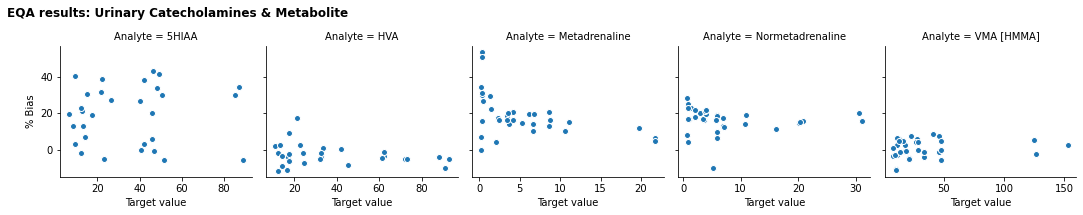

In [61]:
eqa_bias_plot(eqa_calculated,'Urinary Catecholamines & Metabolite')

Next, plot for all schemes in the eqa data

In [62]:
def eqa_bias_multi_plot(df):
    '''
    Plot % bias against target value for all analytes in ALL schemes in a dataframe df
    '''
    for scheme in df['Scheme name'].unique():
        eqa_bias_plot(df, scheme)

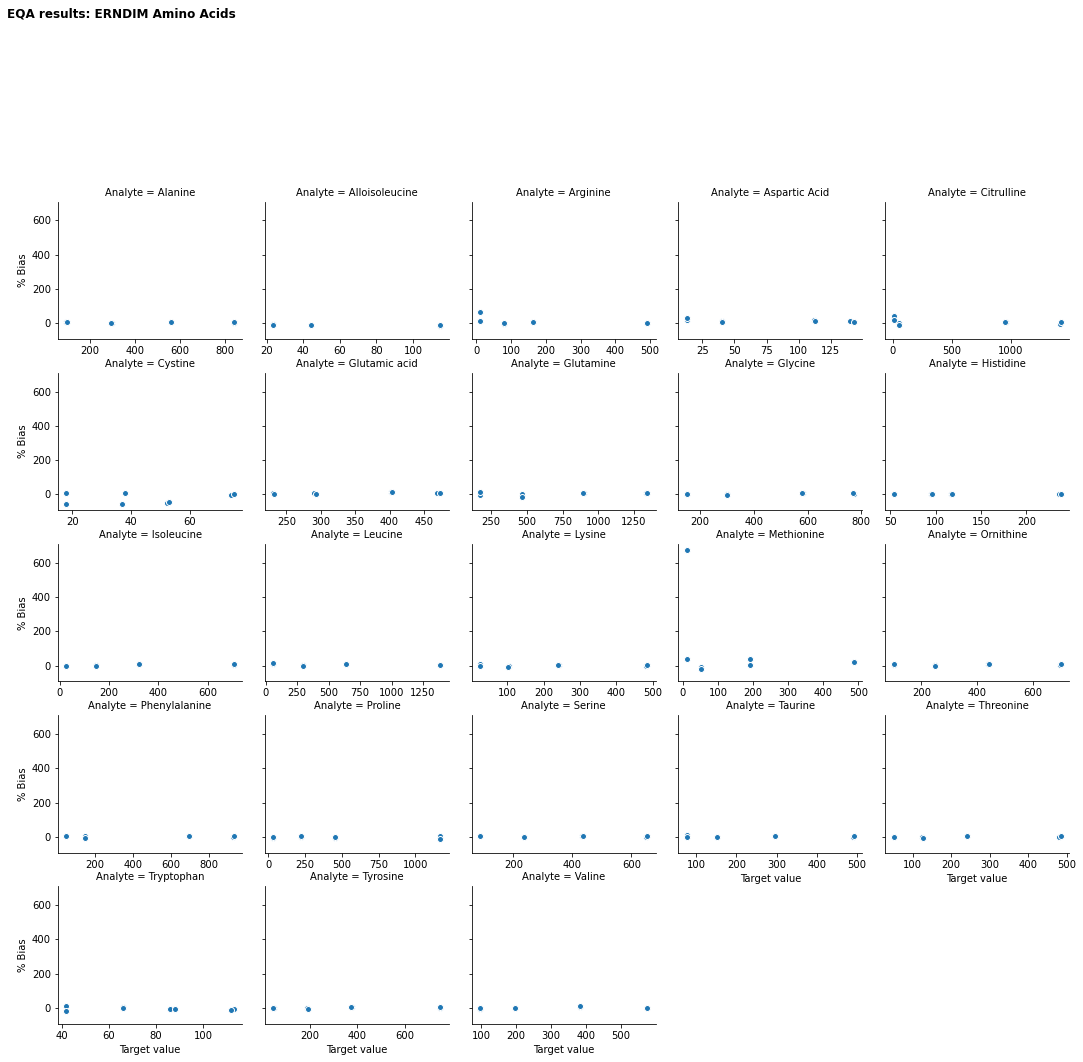

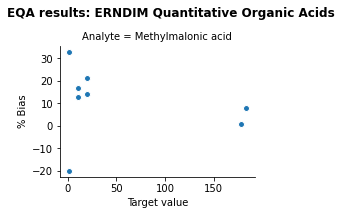

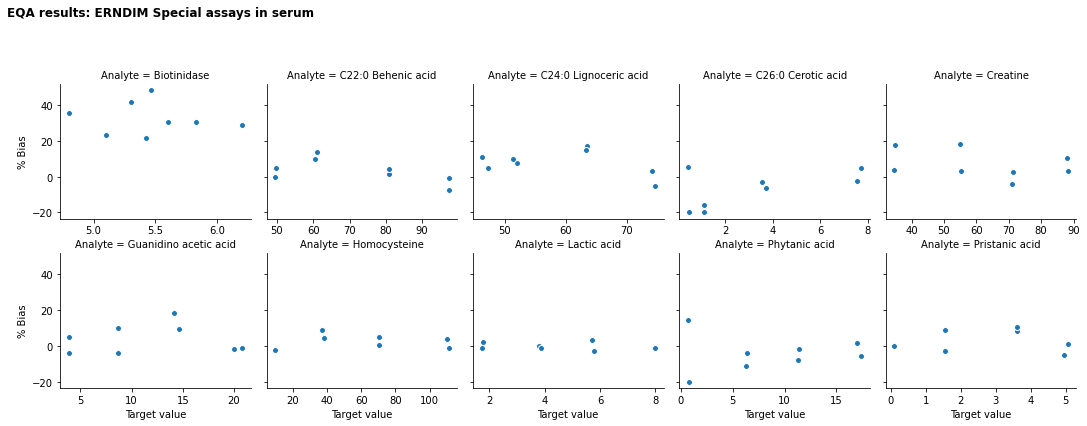

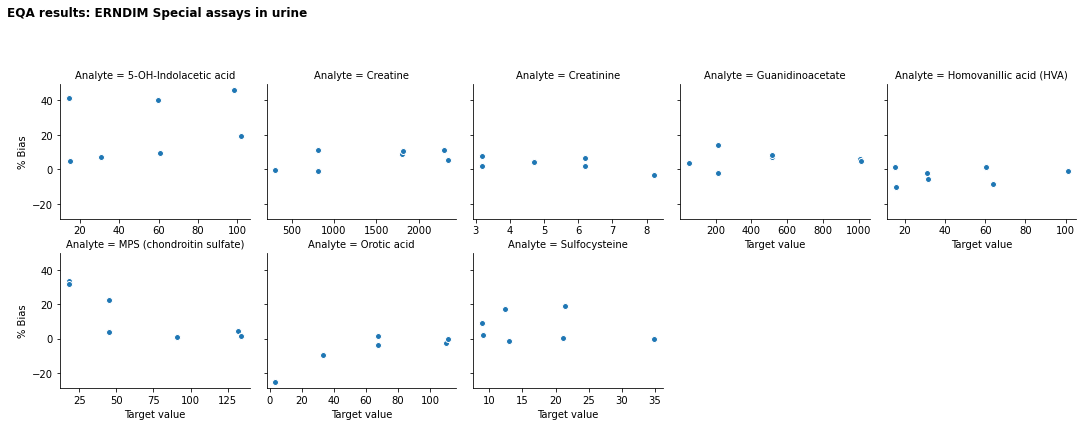

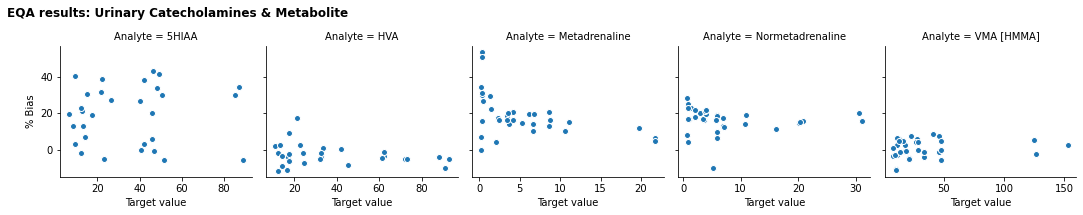

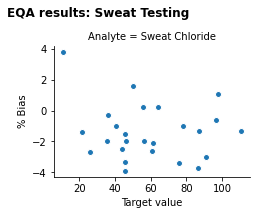

In [64]:
eqa_bias_multi_plot(eqa_calculated)

## Calculate EQA summary statistics

Finally, we can calculate aggregate statistics across all specimens and distributions. This assumes that the %bias is constant throughout the measurable range (may not be true)

In [212]:
eqa_calculated

,Analyte,Specimen,Pool,Scheme name,Standard Uncertainty,Result,Targ,% Bias,% uncertainty in target value
33,5HIAA,236A,C412,Urinary Catecholamines & Metabolite,0.23,7.9,6.6,19.7,3.5
34,5HIAA,236B,C404,Urinary Catecholamines & Metabolite,0.27,15.4,12.7,21.3,2.1
35,5HIAA,236C,C405,Urinary Catecholamines & Metabolite,0.34,20.8,17.5,18.9,1.9
36,5HIAA,237A,C401,Urinary Catecholamines & Metabolite,0.54,28.9,22.0,31.4,2.5
37,5HIAA,237B,C402,Urinary Catecholamines & Metabolite,1.46,111.0,85.3,30.1,1.7
...,...,...,...,...,...,...,...,...,...
193,VMA [HMMA],245B,C395,Urinary Catecholamines & Metabolite,0.61,19.6,20.7,-5.3,2.9
194,VMA [HMMA],245C,C396,Urinary Catecholamines & Metabolite,1.23,45.1,47.8,-5.6,2.6
195,VMA [HMMA],246A,C401,Urinary Catecholamines & Metabolite,0.57,28.4,28.4,0.0,2.0
196,VMA [HMMA],246B,C402,Urinary Catecholamines & Metabolite,0.88,47.4,47.4,0.0,1.9


In [60]:
def eqa_summary_statistics(df):
    '''
    Display a table showing the mean bias, standard deviation of the bias, average % uncertainty in the target value,
    combined uncertainty of the mean % bias and expanded uncertainty of % bias (using a coverage factor of 2)
    '''
    
    eqa_summary = df.groupby(['Scheme name','Analyte']).agg({'Targ':['min','max'],'% Bias':['mean','std'],'% uncertainty in target value':'mean'})
    
    ## Function used to combined uncertainties
    def combined_uncertainty(std,target_value_uncert):
        return np.sqrt(std**2 + target_value_uncert**2)
    
    ## Combine standard deviation of bias with average uncertainty in the target value
    eqa_summary['Combined uncertainty of % bias'] = eqa_summary.apply(lambda x: combined_uncertainty(x[('% Bias','std')],x[('% uncertainty in target value', 'mean')]), axis = 1)
    
    ## Calculate expanded uncertainty in the bias estimate (using coverage factor k=2)
    eqa_summary['Expanded uncertainty of % bias'] = eqa_summary['Combined uncertainty of % bias'].apply(lambda x: x*2)
    
    return eqa_summary.round(1)

In [61]:
eqa_summary_statistics(eqa_calculated)

Targ        % Bias  \
                                                       min    max   mean   
Scheme name                         Analyte                                
Urinary Catecholamines & Metabolite 5HIAA              6.6   89.0   19.2   
                                    HVA               10.9   93.1   -2.9   
                                    Metadrenaline      0.2   21.8   18.9   
                                    Normetadrenaline   0.7   31.0   16.1   
                                    VMA [HMMA]         8.0  153.0    0.6   

                                                            \
                                                       std   
Scheme name                         Analyte                  
Urinary Catecholamines & Metabolite 5HIAA             15.9   
                                    HVA                5.9   
                                    Metadrenaline     11.7   
                                    Normetadrenaline   7.0   
                                    VMA [HMMA]         5.0   

                                                     % uncertainty in target value  \
                                                                              mean   
Scheme name                         Analyte                                          
Urinary Catecholamines & Metabolite 5HIAA                                      2.1   
                                    HVA                                        2.7   
                                    Metadrenaline                              1.9   
                                    Normetadrenaline                           1.6   
                                    VMA [HMMA]                                 2.5   

                                                     Combined uncertainty of % bias  \
                                                                                      
Scheme name                         Analyte                                           
Urinary Catecholamines & Metabolite 5HIAA                                      16.0   
                                    HVA                                         6.4   
                                    Metadrenaline                              11.8   
                                    Normetadrenaline                            7.2   
                                    VMA [HMMA]                                  5.6   

                                                     Expanded uncertainty of % bias  
                                                                                     
Scheme name                         Analyte                                          
Urinary Catecholamines & Metabolite 5HIAA                                      32.1  
                                    HVA                                        12.9  
                                    Metadrenaline                              23.6  
                                    Normetadrenaline                           14.3  
                                    VMA [HMMA]                                 11.2

# Performance targets

Performance targets for each measurand are detailed in **ADD.BIO 6378**: *BGU Quality Monitoring Processes (Appendix 4)*

Import the performance targets, rename the columns and round to one decimal place.

In [36]:
def import_performance_targets(filepath):
    performance_targets = pd.read_excel(filepath,skiprows=2
                                       ,names=['Assay','Measurand','Biol CVi','Biol CVg'
                                               ,'Anal CV Optimal','Anal CV Desirable','Anal CV Minimal'
                                              ,'Bias Optimal','Bias Desirable','Bias Minimal'
                                              ,'TE Optimal','TE Desirable','TE Minimal','Source of performance targets'])
    performance_targets = performance_targets.drop(columns=['Biol CVi','Biol CVg','Source of performance targets'])
    return performance_targets.round(1)

In [41]:
performance_targets = import_performance_targets('data//raw_data/performance_targets_january_2021.xlsx')
performance_targets.head()

,Assay,Measurand,Anal CV Optimal,Anal CV Desirable,Anal CV Minimal,Bias Optimal,Bias Desirable,Bias Minimal,TE Optimal,TE Desirable,TE Minimal
0,Amino acids (CSF),Glycine,5.0,10.0,15.0,5.0,10.0,15.0,13.2,26.5,39.8
1,Amino acids (CSF),Serine,5.0,10.0,15.0,5.0,10.0,15.0,13.2,26.5,39.8
2,Amino acids (Plasma),Alanine,3.7,7.4,11.0,7.2,14.4,21.6,13.3,26.6,39.8
3,Amino acids (Plasma),Alloisoleucine,3.9,7.8,11.6,6.0,12.0,18.0,12.4,24.8,37.2
4,Amino acids (Plasma),Arginine,4.8,9.6,14.5,4.9,9.8,14.7,12.9,25.7,38.6


Performance against imprecision, bias and total allowable error is assessed against three targets:
* Optimal
* Desirable
* Minimal

Define a function to categorise the value obtained against these three targets.

In [38]:
def performance(value, optimal, desirable, minimal):
    if value < optimal:
        return "Optimal"
    elif value < desirable:
        return "Desirable"
    elif value < minimal:
        return "Minimal"
    else:
        return "Not met"

## Imprecision targets

Calculate performance against imprecision targets, and plot

In [42]:
def imprecision_performance(qc_data, assay):
    assay_qc_summary = qc_aggregated(qc_data,assay,10)
    targets = performance_targets[performance_targets['Assay'] == assay]
    assay_qc_summary = assay_qc_summary.merge(right=targets,on='Measurand',how='outer')
    assay_qc_summary['CV performance'] = assay_qc_summary.apply(lambda x: performance(x['% CV'],x['Anal CV Optimal'],x['Anal CV Desirable'],x['Anal CV Minimal']), axis = 1)
    return assay_qc_summary[['Measurand','% CV','CV performance']]

In [43]:
imprecision_performance(qc_data,'Amino acids (Plasma)')

,Measurand,% CV,CV performance
0,Alanine,3.50,Optimal
1,Alloisoleucine,3.30,Optimal
2,Arginine,5.45,Desirable
3,Aspartic acid,5.50,Optimal
4,Citrulline,5.05,Optimal
5,Glutamic acid,6.80,Optimal
6,Glutamine,4.85,Desirable
7,Glycine,3.85,Desirable
8,Histidine,4.10,Desirable
9,Isoleucine,5.30,Desirable


## Bias targets

In [229]:
df = eqa_summary_statistics(eqa_calculated)

In [233]:
df

% Bias        \
                                                       mean   std   
Scheme name                         Analyte                         
Urinary Catecholamines & Metabolite 5HIAA              19.2  15.9   
                                    HVA                -2.9   5.9   
                                    Metadrenaline      18.9  11.7   
                                    Normetadrenaline   16.1   7.0   
                                    VMA [HMMA]          0.6   5.0   

                                                     % uncertainty in target value  \
                                                                              mean   
Scheme name                         Analyte                                          
Urinary Catecholamines & Metabolite 5HIAA                                      2.1   
                                    HVA                                        2.7   
                                    Metadrenaline                              1.9   
                                    Normetadrenaline                           1.6   
                                    VMA [HMMA]                                 2.5   

                                                     Combined uncertainty of % bias  \
                                                                                      
Scheme name                         Analyte                                           
Urinary Catecholamines & Metabolite 5HIAA                                      16.0   
                                    HVA                                         6.4   
                                    Metadrenaline                              11.8   
                                    Normetadrenaline                            7.2   
                                    VMA [HMMA]                                  5.6   

                                                     Expanded uncertainty of % bias  
                                                                                     
Scheme name                         Analyte                                          
Urinary Catecholamines & Metabolite 5HIAA                                      32.1  
                                    HVA                                        12.9  
                                    Metadrenaline                              23.6  
                                    Normetadrenaline                           14.3  
                                    VMA [HMMA]                                 11.2

In [231]:
targets = performance_targets[performance_targets['Assay'] == 'VMA and HVA (Urine)']

In [232]:
targets

,Assay,Measurand,Anal CV Optimal,Anal CV Desirable,Anal CV Minimal,Bias Optimal,Bias Desirable,Bias Minimal,TE Optimal,TE Desirable,TE Minimal
112,VMA and HVA (Urine),Urine HVA,5.0,10.0,15.0,7.5,15.0,22.5,15.8,31.5,47.2
113,VMA and HVA (Urine),Urine VMA,5.6,11.1,16.6,6.5,13.0,19.5,15.7,31.3,47.0
114,VMA and HVA (Urine),Urine HVA /creatinine ratio,5.0,10.0,15.0,7.5,15.0,22.5,15.8,31.5,47.2
115,VMA and HVA (Urine),Urine VMA/creatinine ratio,5.0,10.0,15.0,7.5,15.0,22.5,15.8,31.5,47.2
